<a href="https://colab.research.google.com/github/Ness731/2022-2_Machine_Learning/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### __Seq2Seq__
순환 신경망을 사용한 번역기 모델로, 인코더와 디코더 모듈로 구성된다.<br>
- 인코더 : RNN cell을 거쳐 Context Vector를 생성한다.
- 디코더 : Context Vector를 입력받아 번역문을 생성한다.<br>

#### 1. Encoder
매 step마다 encoder의 RNN cell에 들어오는 input은 다음과 같다. <br>
1. 현재 단어 x_t에 대한 embedding vector
2. 이전 setp인 t-1에서의 hidden state h_t-1

한 번의 step을 거치면 t시점의 hidden state가 출력된다.<br>

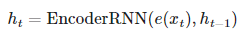

첫 input과 마지막 input은 문장의 시작과 끝을 나타내는 토큰 `<sos>`와 `<eos>`이므로,<br> 해당 토큰에 대해선 대게 지정된 값으로 처리한다. (보통 0을 삽입)

#### 2. Decoder
문장의 마지막 단어에 대한 step을 T라고 했을 때, 오직 h_T를 이용하여 디코딩 작업을 수행한다.<br>
매 step마다 decoder의 RNN cell에 들어오는 input은 다음과 같다. <br>
1. 현재 단어에 y_t에 대한 embedding vector
2. 이전 setp인 t-1에서의 hidden state s_t-1<br>
이때, 디코더의 맨 첫 번째 hidden state s_0은 인코더에서 넘겨준 h_T와 같다.<br>
`s_0 == h_T`<br>

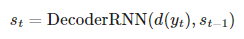

디코더의 매 step에서 생성되는 hidden state를 이용하여 다음 단어 y^_t를 예측한다. <br>
즉, 디코더에서는 항상 한 번의 스텝마다 한 개의 단어를 차례대로 생성한다.
<br>

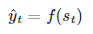

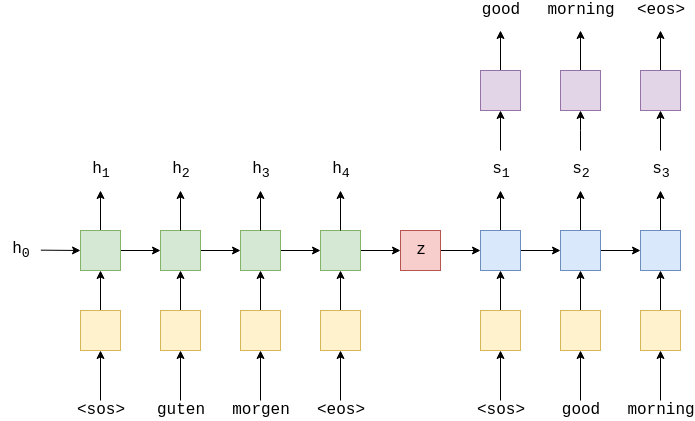

In [1]:
import torchtext
torchtext.__version__

'0.10.1'

In [2]:
pip install torchtext==0.10.1 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

## Data load

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [8]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [9]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

논문에 의하면 원문을 토큰화한 후 reverse 하면 더 쉽게 모델을 최적화할 수 있다고 한다.

In [10]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '', 
            eos_token = '', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '', 
            eos_token = '', 
            lower = True)

In [11]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 423kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 111kB/s] 


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 106kB/s]


In [12]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [13]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


위의 토큰화 함수를 거쳐 각 문장들이 정상적으로 토큰화되었음을 확인할 수 있다. 특히 독일어 문장은 reverse까지 잘 되어있다.

In [14]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [15]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7852
Unique tokens in target (en) vocabulary: 5892


### 모델 설계

모델에 사용되는 하이퍼파라미터는 다음과 같다.<br>
- __input_dim__ : 입력 데이터는 원핫 인코딩된 각 단어이기 때문에, 입력 차원은 __원핫 벡터 크기__이다.
- __emb_dim__ : 원핫 벡터를 입력받은 후 임베딩 벡터로 변환할 때 사용할 __임베딩 벡터 크기__
- __hid_dim__ : hidden state의 크기
- __n_layers__ : RNN cell의 개수

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

### Encoder

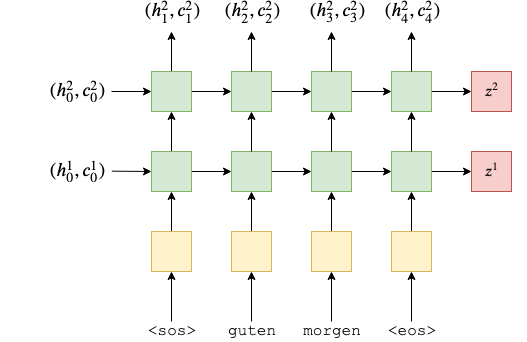

LSTM은 Vanila RNN과 다르게 state가 2개이다. <은닉 상태 h와 셀 상태 c>. 따라서 리턴 값은 hidden, cell이다.

In [17]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()

    self.hid_dim = hid_dim
    self.n_layers = n_layers

     # 인코딩 벡터 -> 임베딩 벡터로 임베딩하는 함수. 따라서 두 벡터의 차원을 input으로 받는다.
    self.embedding = nn.Embedding(input_dim, emb_dim)

    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
    embedded = self.dropout(self.embedding(src))
    # 임베딩 벡터를 rnn cell에 입력한 후 최종적으로 생성된 hidden state를 output으로 설정
    outputs, (hidden, cell) = self.rnn(embedded) 
    return hidden, cell

### Decoder
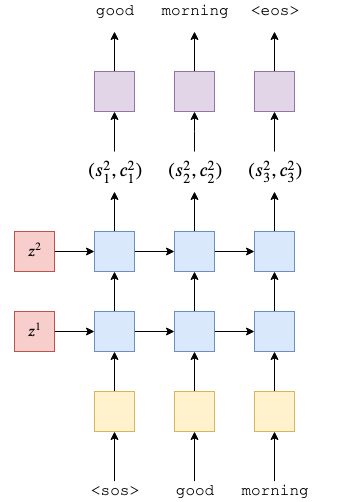

In [25]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()

    self.output_dim = output_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(output_dim, emb_dim)

    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

    self.fc_out = nn.Linear(hid_dim, output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, cell):
    # 지정한 dimension 자리에 size가 1인 빈 공간을 채워주면서 차원을 확장
    input = input.unsqueeze(0)

    embedded = self.dropout(self.embedding(input))

    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

    prediction = self.fc_out(output.squeeze(0))

    return prediction, hidden, cell

## Seq2Seq

In [20]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

    assert encoder.hid_dim == decoder.hid_dim, \
      "Hidden dimensions of encoder and decoder must be equal!"
    assert encoder.n_layers == decoder.n_layers, \
      "Encoder and decoder must have equal number of layers!"
    
  def forward(self, src, trg, teacher_forcing_ratio = 0.5):
    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    # 사이즈를 맞추기 위한 제로패딩
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

    hidden, cell = self.encoder(src)
    input = trg[0, :]

    for t in range(1, trg_len):
      output, hidden, cell = self.decoder(input, hidden, cell)

      outputs[t] = output

      teacher_force = random.random() < teacher_forcing_ratio

      top1 = output.argmax(1)

      input = trg[t] if teacher_force else top1

    return outputs

### Train Model

In [26]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [27]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

The model has 13,897,476 trainable parameters


In [28]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 38s
	Train Loss: 5.050 | Train PPL: 155.950
	 Val. Loss: 5.015 |  Val. PPL: 150.600
Epoch: 02 | Time: 0m 36s
	Train Loss: 4.524 | Train PPL:  92.196
	 Val. Loss: 5.065 |  Val. PPL: 158.372
Epoch: 03 | Time: 0m 36s
	Train Loss: 4.276 | Train PPL:  71.978
	 Val. Loss: 4.709 |  Val. PPL: 110.927
Epoch: 04 | Time: 0m 37s
	Train Loss: 4.062 | Train PPL:  58.117
	 Val. Loss: 4.598 |  Val. PPL:  99.332
Epoch: 05 | Time: 0m 37s
	Train Loss: 3.881 | Train PPL:  48.491
	 Val. Loss: 4.483 |  Val. PPL:  88.542
Epoch: 06 | Time: 0m 38s
	Train Loss: 3.740 | Train PPL:  42.083
	 Val. Loss: 4.283 |  Val. PPL:  72.427
Epoch: 07 | Time: 0m 37s
	Train Loss: 3.615 | Train PPL:  37.138
	 Val. Loss: 4.212 |  Val. PPL:  67.515
Epoch: 08 | Time: 0m 36s
	Train Loss: 3.479 | Train PPL:  32.418
	 Val. Loss: 4.097 |  Val. PPL:  60.131
Epoch: 09 | Time: 0m 36s
	Train Loss: 3.352 | Train PPL:  28.563
	 Val. Loss: 4.006 |  Val. PPL:  54.937
Epoch: 10 | Time: 0m 36s
	Train Loss: 3.261 | Train PPL